In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
%config Completer.use_jedi = False

In [2]:
all_boxes = pd.read_csv("./data/train_merged.csv")
all_boxes.head(50)
all_boxes["area"] = (all_boxes["x_max"] - all_boxes["x_min"]) * (all_boxes["y_max"] - all_boxes["y_min"])
all_boxes.head()

,Unnamed: 0,image_id,Label,x_min,y_min,x_max,y_max,area
0,0,00013118_008.png,Atelectasis,225.084746,547.019217,311.864407,626.205657,6871.772479
1,1,00014716_007.png,Atelectasis,686.101695,131.543498,871.593220,445.035024,58150.021258
2,2,00029817_009.png,Atelectasis,221.830508,317.053115,376.949153,534.002268,33652.858374
3,3,00014687_001.png,Atelectasis,726.237288,494.951420,867.254237,550.273454,7801.344441
4,4,00017877_001.png,Atelectasis,660.067797,569.780787,860.745763,647.882481,15673.289285


In [3]:
all_images = os.listdir("./data/all_images")

              Unnamed: 0
Label                   
Atelectasis          459
Cardiomegaly        5573
Effusion             153
Infiltrate          1370
Nodule/Mass         2744
Pneumonia            120
Pneumothorax         324


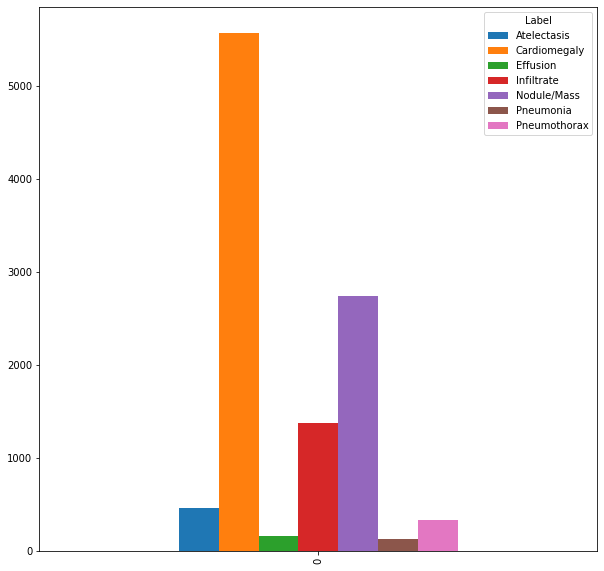

In [4]:
labels_distribution = pd.DataFrame(all_boxes.groupby(["Label"]).count().T.iloc[0])
print(labels_distribution)
labels_distribution.T.reset_index().drop("index", axis=1).plot.bar(figsize=(10,10))
plt.show()

Atelectasis


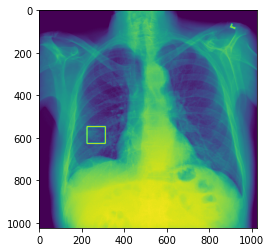

Atelectasis


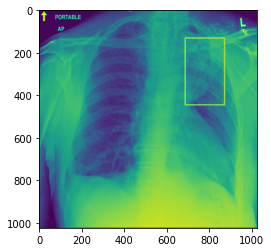

Atelectasis


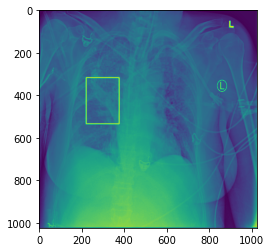

Atelectasis


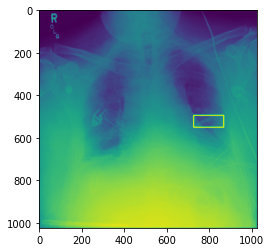

Atelectasis


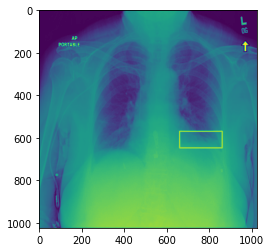

In [5]:
for num in range(min(all_boxes.size, 5)):
    instance = all_boxes.iloc[num]

    x_min = int(instance.x_min)
    y_min = int(instance.y_min)
    x_max = int(instance.x_max)
    y_max = int(instance.y_max)
    
    path = os.path.join("./data/all_images/", instance["image_id"])
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    cv2.rectangle(image,
              (x_min, y_min),
              (x_max, y_max),
              (220, 200, 220), 5)
    print(instance.Label)
    plt.imshow(image, label=instance.Label)
    plt.show()

In [32]:
label_names = all_boxes.Label.unique()
label_name_2_idx = {label: i for i, label in enumerate(label_names)}
print(label_names)

['Atelectasis' 'Cardiomegaly' 'Effusion' 'Infiltrate' 'Nodule/Mass'
 'Pneumonia' 'Pneumothorax']


Area distribution among all labels

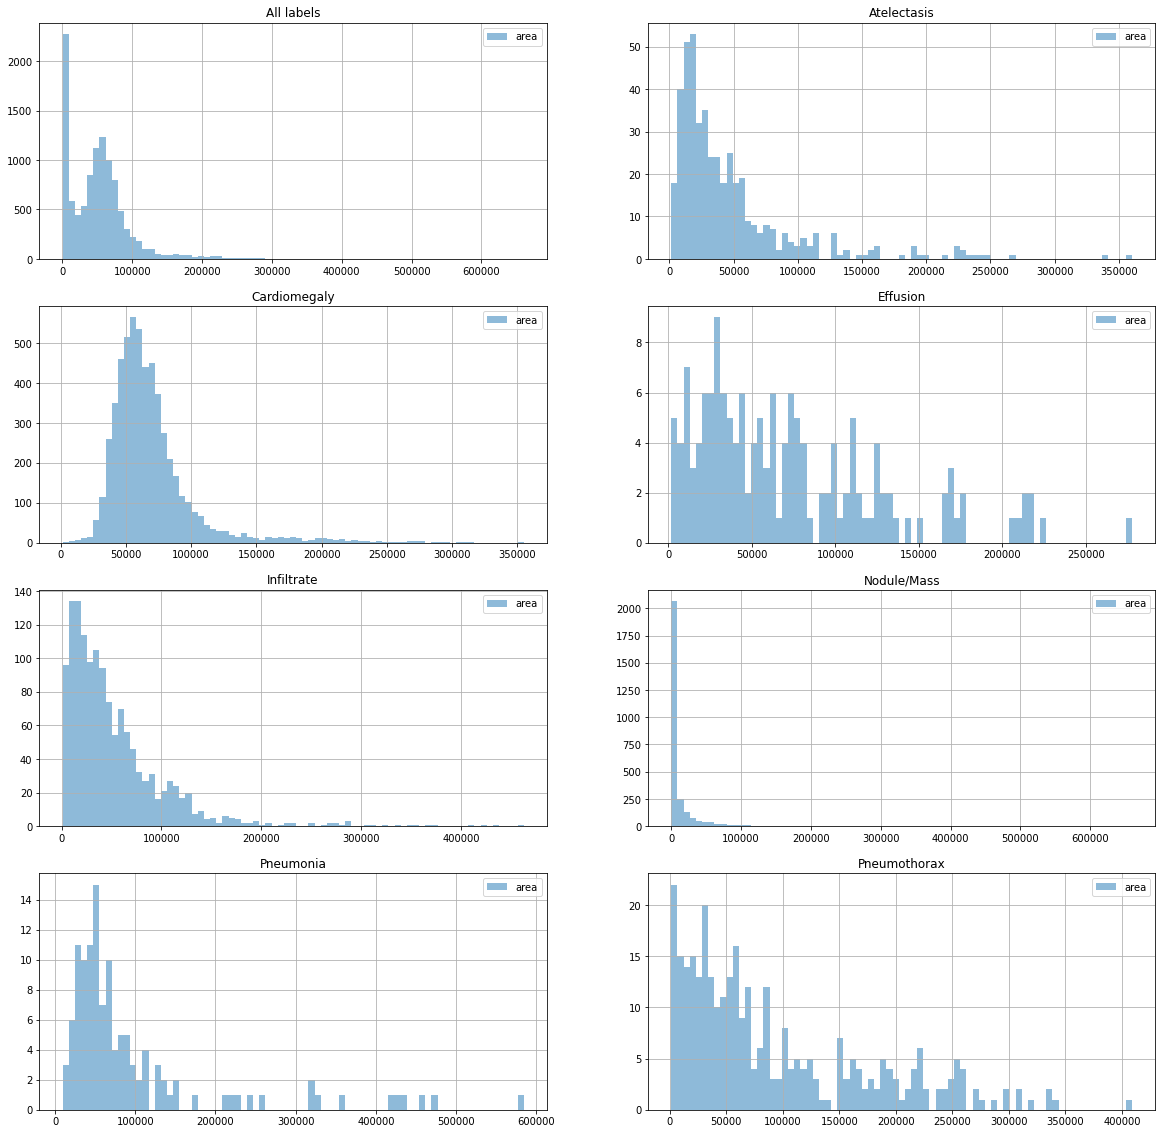

In [8]:
figsize = (20, 20)
bins = 75
fig, axs = plt.subplots(4, 2)
all_boxes.area.hist(bins=bins, ax=axs[0][0], figsize=figsize, alpha=0.5, legend=True)
axs[0][0].title.set_text("All labels")
row = 0
col = 1
for i, label in enumerate(label_names):
    all_boxes[all_boxes.Label == label]['area'].hist(bins=bins, ax=axs[row][col], 
                                                     figsize=figsize, alpha=0.5, legend=True)
    axs[row][col].title.set_text(label)
    col += 1
    if col == 2:
        col = 0
        row += 1
plt.show()

#We can us ethis info to correct the area in the postprocessing phase

Amount of mutual occurances


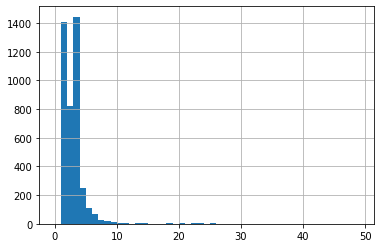

In [9]:
print("Amount of mutual occurances")
all_boxes.groupby("image_id").count().Label.hist(bins=np.arange(50))
plt.show()

In [10]:
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

num_samples = len(list(all_boxes.groupby("image_id").groups.keys()))
mutual_occurances_unique = np.zeros((len(label_names), len(label_names)), dtype=np.int)
for image_id in tqdm(list(all_boxes.groupby("image_id").groups.keys())):
    labels = all_boxes[all_boxes.image_id == image_id].Label.values
    labels = np.unique(labels)
    if len(labels) == 1:
        continue
    for i, label1 in enumerate(labels):
        for label2 in labels[i + 1:]:
            mutual_occurances_unique[label_name_2_idx[label1]][label_name_2_idx[label2]] += 1
            mutual_occurances_unique[label_name_2_idx[label2]][label_name_2_idx[label1]] += 1
print(mutual_occurances_unique / num_samples)

#We can use this distribution as an apriori probabilities of occurances of 2 classes at once

100%|██████████| 4210/4210 [00:02<00:00, 1574.16it/s]

[[0.0000 0.0090 0.0048 0.0131 0.0128 0.0000 0.0038]
 [0.0090 0.0000 0.0005 0.0439 0.0663 0.0012 0.0043]
 [0.0048 0.0005 0.0000 0.0059 0.0014 0.0007 0.0010]
 [0.0131 0.0439 0.0059 0.0000 0.0268 0.0031 0.0026]
 [0.0128 0.0663 0.0014 0.0268 0.0000 0.0007 0.0052]
 [0.0000 0.0012 0.0007 0.0031 0.0007 0.0000 0.0005]
 [0.0038 0.0043 0.0010 0.0026 0.0052 0.0005 0.0000]]


10743it [00:01, 9087.44it/s]
459it [00:00, 7891.37it/s]
5573it [00:00, 8386.22it/s]
153it [00:00, 7067.96it/s]
1370it [00:00, 9132.80it/s]
2744it [00:00, 13159.29it/s]
120it [00:00, 6107.39it/s]
324it [00:00, 6550.82it/s]


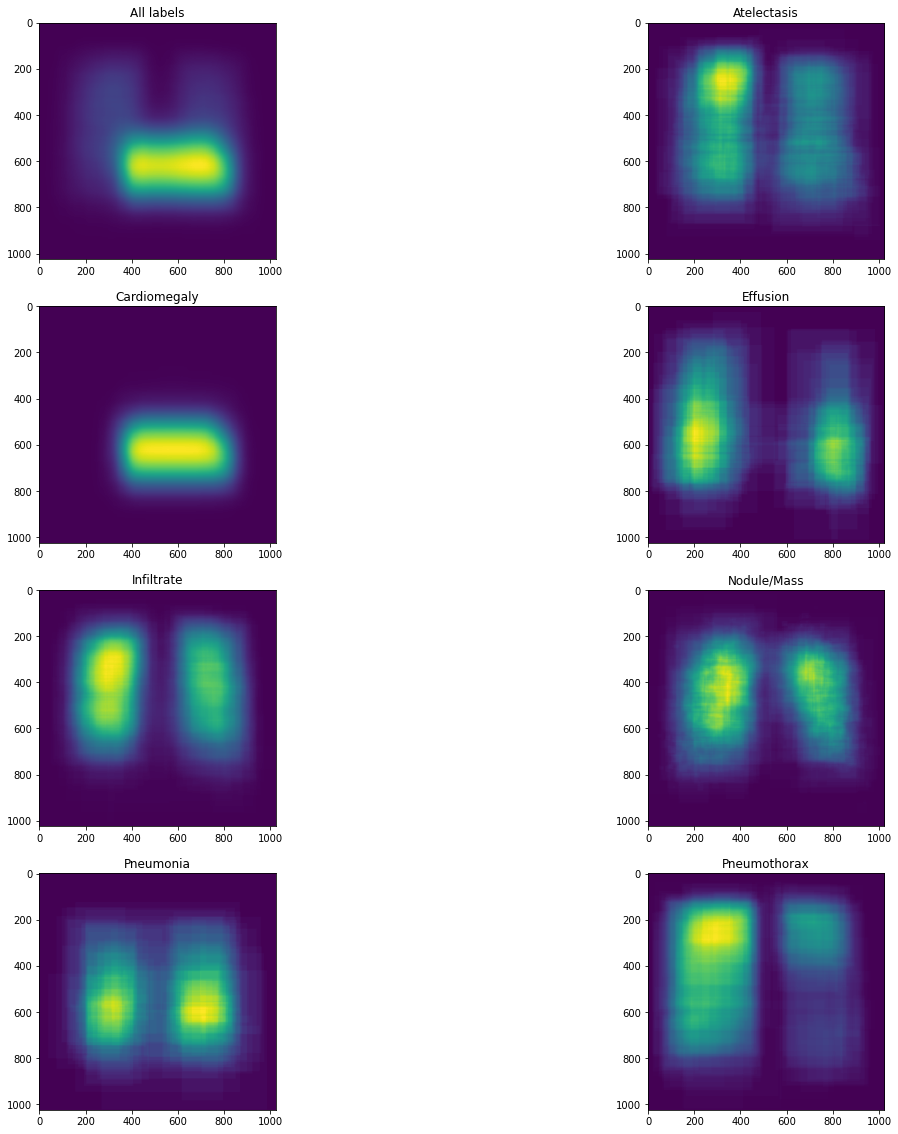

In [31]:
hot_map = np.zeros((8, 1024, 1024), dtype=np.int)
figsize = (20, 20)
fig, axs = plt.subplots(4, 2, figsize=figsize)
row = 0
col = 1

for sample in tqdm(all_boxes.iterrows()):
    x0, y0, x1, y1 = int(sample[1].x_min), int(sample[1].y_min), int(sample[1].x_max), int(sample[1].y_max)
    hot_map[0, y0:y1, x0:x1] += 1
axs[0][0].title.set_text("All labels")
axs[0][0].imshow(hot_map[0])
    
for i, label in enumerate(label_names): 
    df = all_boxes[all_boxes.Label == label]
    for sample in tqdm(df.iterrows()):
        x0, y0, x1, y1 = int(sample[1].x_min), int(sample[1].y_min), int(sample[1].x_max), int(sample[1].y_max)
        hot_map[i + 1, y0:y1, x0:x1] += 1
    axs[row][col].title.set_text(label)
    axs[row][col].imshow(hot_map[i + 1])
    col += 1
    if col == 2:
        col = 0
        row += 1
plt.show()

So here we can make quiet confident decision, that some classes are distributed in small local zones (such as pneumothorax and cardiomegaly)